### MANCOVA
İkiden fazla grupta, iki bağımlı değişkenin ortalamalarının karşılaştırılmasında bağımlı değişkenlerin etkileyen başka bir değişkenin etkisinin varlığı

https://www.kaggle.com/jacksonchou/hr-data-for-analytics

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats  
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd 
from statsmodels.stats.multicomp import MultiComparison
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from pingouin import multivariate_normality
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df_all = pd.read_csv("performans.csv", sep=";")
df_all = df_all.dropna()

In [3]:
def proje_rank(row):
    if ((row["proje_sayisi"] > 1) & (row["proje_sayisi"] <= 3)):
        return 3
    elif ((row["proje_sayisi"] > 3) & (row["proje_sayisi"] < 5)):
        return 4
    elif ((row["proje_sayisi"] >= 5) & (row["proje_sayisi"] <= 6)):
        return 5
    else :
        pass

df_all['proje_sayisi'] = df_all.apply (lambda row: proje_rank(row), axis=1)

## Amaç
#### Aylık Çalışma Süresi kontrol altına alındığında Proje Sayısına göre çalışanların Memnuniyeti ve Performansı değişiyor mu?

In [4]:
df_mc = df_all.drop("tecrube", axis=1)

In [5]:
df_mc.describe().T

,count,mean,std,min,25%,50%,75%,max
memnuniyet_seviyesi,10812.0,63.543748,22.719062,11.0,46.0,66.0,82.00,99.0
performans_olcumu,10812.0,70.617185,16.847800,36.0,55.0,69.0,86.00,99.0
proje_sayisi,10812.0,3.788938,0.808815,3.0,3.0,4.0,4.00,5.0
aylik_calisma_suresi,10812.0,197.419071,47.275780,101.0,155.0,195.0,239.25,298.0


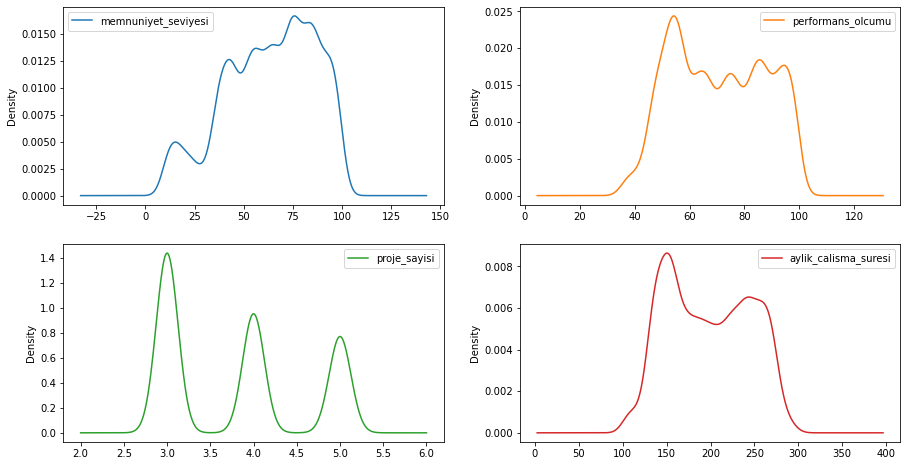

In [91]:
df_mc.plot(kind='density', subplots=True, layout=(2,2), sharex=False, figsize=(15, 8))
plt.show()

,Count
proje_sayisi,
3,4918
4,3258
5,2636


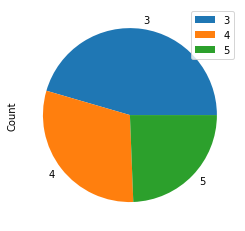

In [17]:
dis = pd.DataFrame(df_mc[['proje_sayisi']].value_counts())
dis = dis.reset_index().set_index('proje_sayisi')
dis.columns = ['Count']
_ = dis.plot.pie(y='Count')
dis

In [18]:
df_mc.corr()

,memnuniyet_seviyesi,performans_olcumu,proje_sayisi,aylik_calisma_suresi
memnuniyet_seviyesi,1.000000,0.219168,0.033418,0.153345
performans_olcumu,0.219168,1.000000,0.239796,0.307002
proje_sayisi,0.033418,0.239796,1.000000,0.266939
aylik_calisma_suresi,0.153345,0.307002,0.266939,1.000000


# Varsayım 1: Verilerin Normal Dağılıma Uyması
##### Ho: Verilerin dağılımı ile Normal Dağılım arasında fark yoktur.(Veriler normal dağılıma uygundur.)
##### Ha: Verilerin dağılımı ile Normal Dağılım arasında fark vardır.(Veriler normal dağılıma uygun değildir.)

In [19]:
df = df_mc.sample(n=2500)

In [20]:
multivariate_normality(df, alpha=.05)

HZResults(hz=903.0804229988411, pval=0.0, normal=False)

H0 red, normal dağılıma uygun değildir. 

# Varsayım 2: Kovaryans Eşitliği
##### Ho: Kovaryans matrisleri arasında fark yoktur. (eşittir)
##### Ha: Kovaryans matrisleri arasında fark vardır. (eşit değildir)

In [22]:
pg.box_m(df_mc, dvs=["memnuniyet_seviyesi", "performans_olcumu", "aylik_calisma_suresi"], group=("proje_sayisi"), alpha=.05)

,Chi2,df,pval,equal_cov
box,NaN,12.0,NaN,False


H0 red, kovaryans matrisleri arasında fark vardır.

# Varsayım 3: Gruplararası Korelasyon Eşitliği

In [6]:
df2 = df_mc[(df_mc.proje_sayisi == 3)]
df3 = df_mc[(df_mc.proje_sayisi == 4)]
df4= df_mc[(df_mc.proje_sayisi == 5)]

<AxesSubplot:>

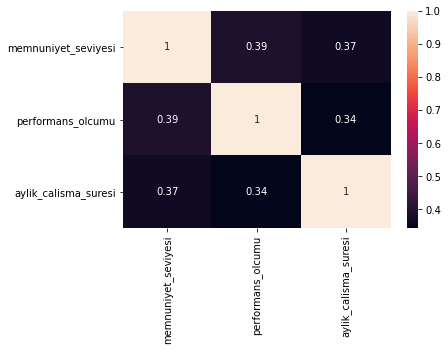

In [76]:
sns.heatmap(df2.drop(["proje_sayisi"], axis=1).corr(), annot=True)

<AxesSubplot:>

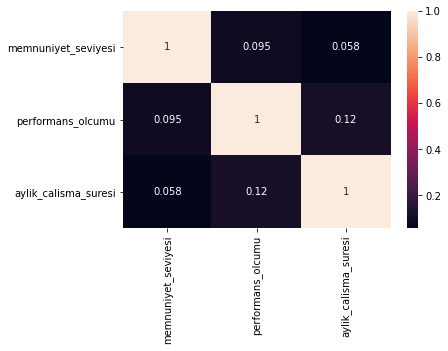

In [77]:
sns.heatmap(df3.drop(["proje_sayisi"], axis=1).corr(), annot=True)

<AxesSubplot:>

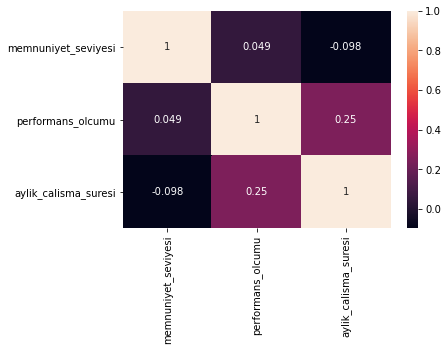

In [78]:
sns.heatmap(df4.drop(["proje_sayisi"], axis=1).corr(), annot=True)

## Varsayım 4: Doğrusal İlişki
Bağımlı değişkenler ile covariate değişken arasında doğrusal ilişki olmalıdır.

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sns

#### Memnuniyet ile Aylık Çalışma arasındaki ilişki

In [57]:
X = df_mc.drop(["memnuniyet_seviyesi", "proje_sayisi", "performans_olcumu"], axis=1)
y = df_mc["memnuniyet_seviyesi"]
X = sm.add_constant(X)
lm = sm.OLS(y,X)
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     memnuniyet_seviyesi   R-squared:                       0.024
Model:                             OLS   Adj. R-squared:                  0.023
Method:                  Least Squares   F-statistic:                     260.3
Date:                 Sun, 05 Dec 2021   Prob (F-statistic):           6.93e-58
Time:                         11:56:03   Log-Likelihood:                -48981.
No. Observations:                10812   AIC:                         9.797e+04
Df Residuals:                    10810   BIC:                         9.798e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   48.9955      0.927     52.843      0.000      47.178      50.813
aylik_calisma_suresi     0.0737      0.005     16.134      0.000       0.065       0.083
==============================================================================
Omnibus:                      450.806   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.902
Skew:                          -0.509   Prob(JB):                    9.28e-108
Kurtosis:                       2.758   Cond. No.                         872.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Performans ile Aylık Çalışma arasındaki ilişki

In [59]:
X = df_mc.drop(["memnuniyet_seviyesi", "proje_sayisi", "performans_olcumu"], axis=1)
y = df_mc["performans_olcumu"]
X = sm.add_constant(X)
lm = sm.OLS(y,X)
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      performans_olcumu   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     1125.
Date:                Sun, 05 Dec 2021   Prob (F-statistic):          1.06e-234
Time:                        11:56:59   Log-Likelihood:                -45341.
No. Observations:               10812   AIC:                         9.069e+04
Df Residuals:                   10810   BIC:                         9.070e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   49.0181      0.662     74.023      0.000      47.720      50.316
aylik_calisma_suresi     0.1094      0.003     33.539      0.000       0.103       0.116
==============================================================================
Omnibus:                     1622.198   Durbin-Watson:                   1.547
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              391.155
Skew:                           0.083   Prob(JB):                     1.15e-85
Kurtosis:                       2.083   Cond. No.                         872.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hem memnuniyet hem de performans ile aylık çalışma süresi arasında doğrusal bir ilişki vardır.

## Varsayım 5: Regresyonların Homojenliği
Covariate ile bağımlı değişkenler arasındaki ilişkinin gücü ve yönü her grupta benzer olmalıdır.
Her bir grupta covariate ile bağımlı değişkenler arasındaki ilişkide bağımsız değişken anlamsız olmalıdır. 

## Her bir Proje Sayısı Grubunun Performansı için Homojenlik

In [79]:
X = df2.drop(["memnuniyet_seviyesi", "performans_olcumu"], axis=1)
y = df2["performans_olcumu"]
X = sm.add_constant(X)
lm = sm.OLS(y,X)
model1 = lm.fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      performans_olcumu   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     654.8
Date:                Sun, 05 Dec 2021   Prob (F-statistic):          1.09e-135
Time:                        12:10:45   Log-Likelihood:                -20457.
No. Observations:                4918   AIC:                         4.092e+04
Df Residuals:                    4916   BIC:                         4.093e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
proje_sayisi            14.3766      0.307     46.878      0.000      13.775      14.978
aylik_calisma_suresi     0.1245      0.005     25.589      0.000       0.115       0.134
==============================================================================
Omnibus:                      277.730   Durbin-Watson:                   1.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.027
Skew:                           0.444   Prob(JB):                     8.29e-50
Kurtosis:                       2.439   Cond. No.                         262.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
X = df3.drop(["memnuniyet_seviyesi", "performans_olcumu"], axis=1)
y = df3["performans_olcumu"]
X = sm.add_constant(X)
lm = sm.OLS(y,X)
model2 = lm.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      performans_olcumu   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     44.40
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           3.13e-11
Time:                        12:10:51   Log-Likelihood:                -13593.
No. Observations:                3258   AIC:                         2.719e+04
Df Residuals:                    3256   BIC:                         2.720e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
proje_sayisi            16.3115      0.327     49.898      0.000      15.671      16.952
aylik_calisma_suresi     0.0414      0.006      6.663      0.000       0.029       0.054
==============================================================================
Omnibus:                     1109.865   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.819
Skew:                          -0.126   Prob(JB):                     1.62e-36
Kurtosis:                       1.927   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
X = df4.drop(["memnuniyet_seviyesi", "performans_olcumu"], axis=1)
y = df4["performans_olcumu"]
X = sm.add_constant(X)
lm = sm.OLS(y,X)
model3 = lm.fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      performans_olcumu   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     179.5
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           1.18e-39
Time:                        12:10:58   Log-Likelihood:                -11046.
No. Observations:                2636   AIC:                         2.210e+04
Df Residuals:                    2634   BIC:                         2.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
proje_sayisi            11.2834      0.290     38.945      0.000      10.715      11.851
aylik_calisma_suresi     0.0889      0.007     13.399      0.000       0.076       0.102
==============================================================================
Omnibus:                      250.705   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.905
Skew:                          -0.367   Prob(JB):                     7.54e-28
Kurtosis:                       2.226   Cond. No.                         203.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Her bir proje sayısı grubu (2,3,4) için aylık çalışma süresi ile performans arasındaki ilişkide proje sayısı değişkeni anlamlı bulunmuştur. Bu varsayım sağlanamamıştır. 

#### Her bir Proje Sayısı Grubunun Memnuniyeti İçin Homojenlik

In [82]:
X = df2.drop(["memnuniyet_seviyesi", "performans_olcumu"], axis=1)
y = df2["memnuniyet_seviyesi"]
X = sm.add_constant(X)
lm = sm.OLS(y,X)
model1 = lm.fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     memnuniyet_seviyesi   R-squared:                       0.137
Model:                             OLS   Adj. R-squared:                  0.137
Method:                  Least Squares   F-statistic:                     780.2
Date:                 Sun, 05 Dec 2021   Prob (F-statistic):          1.72e-159
Time:                         12:13:16   Log-Likelihood:                -21512.
No. Observations:                 4918   AIC:                         4.303e+04
Df Residuals:                     4916   BIC:                         4.304e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
proje_sayisi             9.9787      0.380     26.255      0.000       9.234      10.724
aylik_calisma_suresi     0.1685      0.006     27.932      0.000       0.157       0.180
==============================================================================
Omnibus:                       18.668   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.185
Skew:                           0.129   Prob(JB):                     0.000113
Kurtosis:                       2.851   Cond. No.                         262.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
X = df3.drop(["memnuniyet_seviyesi", "aylik_calisma_suresi"], axis=1)
y = df3["memnuniyet_seviyesi"]
X = sm.add_constant(X)
lm = sm.OLS(y,X)
model2 = lm.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     memnuniyet_seviyesi   R-squared:                       0.009
Model:                             OLS   Adj. R-squared:                  0.009
Method:                  Least Squares   F-statistic:                     29.81
Date:                 Sun, 05 Dec 2021   Prob (F-statistic):           5.12e-08
Time:                         12:13:24   Log-Likelihood:                -14379.
No. Observations:                 3258   AIC:                         2.876e+04
Df Residuals:                     3256   BIC:                         2.877e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
performans_olcumu     0.1210      0.022      5.460      0.000       0.078       0.164
proje_sayisi         15.1775      0.418     36.320      0.000      14.358      15.997
==============================================================================
Omnibus:                      312.542   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              406.486
Skew:                          -0.832   Prob(JB):                     5.40e-89
Kurtosis:                       3.476   Cond. No.                         90.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
X = df4.drop(["memnuniyet_seviyesi", "aylik_calisma_suresi"], axis=1)
y = df4["memnuniyet_seviyesi"]
X = sm.add_constant(X)
lm = sm.OLS(y,X)
model3 = lm.fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     memnuniyet_seviyesi   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     6.409
Date:                 Sun, 05 Dec 2021   Prob (F-statistic):             0.0114
Time:                         12:13:29   Log-Likelihood:                -12473.
No. Observations:                 2636   AIC:                         2.495e+04
Df Residuals:                     2634   BIC:                         2.496e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
performans_olcumu     0.0820      0.032      2.532      0.011       0.018       0.146
proje_sayisi         10.9717      0.500     21.948      0.000       9.991      11.952
==============================================================================
Omnibus:                      559.520   Durbin-Watson:                   1.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.245
Skew:                          -0.596   Prob(JB):                     1.68e-55
Kurtosis:                       2.064   Cond. No.                         72.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Her bir proje sayısı grubu (2,3,4) için aylık çalışma süresi ile memnuniyet arasındaki ilişkide proje sayısı değişkeni anlamlı bulunmuştur. Bu varsayım sağlanamamıştır. 

## Doğru Eğimlerinin Homejenliği

In [42]:
import scipy

### Her bir proje sayısı grubu için memnuniyet seviyesi ve aylık çalışma süresi arasındaki ilişkide eğim

In [85]:
slope1, intercept1, r_value1, p_value1, std_err1 = scipy.stats.linregress(df2["memnuniyet_seviyesi"], df2["aylik_calisma_suresi"])
slope2, intercept2, r_value2, p_value2, std_err2 = scipy.stats.linregress(df3["memnuniyet_seviyesi"], df3["aylik_calisma_suresi"])
slope3, intercept3, r_value3, p_value3, std_err3 = scipy.stats.linregress(df4["memnuniyet_seviyesi"], df4["aylik_calisma_suresi"])

In [86]:
dict=({"1.Grup Eğim":slope1,"1. Grup sabit": intercept1, "1.Grup anlamlılık": p_value1,
       "2.Grup Eğim":slope2, "2. Grup sabit": intercept2, "2.Grup anlamlılık": p_value2,
       "3.Grup Eğim":slope3, "3. Grup sabit": intercept3, "3.Grup anlamlılık": p_value3})
dict

{'1.Grup Eğim': 0.8130503933723938,
 '1. Grup sabit': 134.0359973314824,
 '1.Grup anlamlılık': 1.7240508951316728e-159,
 '2.Grup Eğim': 0.12707427496080517,
 '2. Grup sabit': 196.6881646600574,
 '2.Grup anlamlılık': 0.0009906943349399207,
 '3.Grup Eğim': -0.16808645096989952,
 '3. Grup sabit': 223.59336493211563,
 '3.Grup anlamlılık': 4.1346322926135383e-07}

##### Her bir proje sayısı grubu için memnuniyet seviyesi ve aylık çalışma süresi arasındaki ilişkide doğru eğimleri homojen değildir. 

### Her bir proje sayısı grubu için performans ölçümü ve aylık çalışma süresi arasındaki ilişkide eğim

In [87]:
slope1, intercept1, r_value1, p_value1, std_err1 = scipy.stats.linregress(df2["performans_olcumu"], df2["aylik_calisma_suresi"])
slope2, intercept2, r_value2, p_value2, std_err2 = scipy.stats.linregress(df3["performans_olcumu"], df3["aylik_calisma_suresi"])
slope3, intercept3, r_value3, p_value3, std_err3 = scipy.stats.linregress(df4["performans_olcumu"], df4["aylik_calisma_suresi"])

In [88]:
dict=({"1.Grup Eğim":slope1,"1. Grup sabit": intercept1, "1.Grup anlamlılık": p_value1,
       "2.Grup Eğim":slope2, "2. Grup sabit": intercept2, "2.Grup anlamlılık": p_value2,
       "3.Grup Eğim":slope3, "3. Grup sabit": intercept3, "3.Grup anlamlılık": p_value3})
dict

{'1.Grup Eğim': 0.9438457557543466,
 '1. Grup sabit': 121.23330402260675,
 '1.Grup anlamlılık': 1.0887851418789368e-135,
 '2.Grup Eğim': 0.3246117520735875,
 '2. Grup sabit': 181.5921822917186,
 '2.Grup anlamlılık': 3.132990599237121e-11,
 '3.Grup Eğim': 0.7181309051434454,
 '3. Grup sabit': 159.20556875663115,
 '3.Grup anlamlılık': 1.1801401700150051e-39}

##### Her bir proje sayısı grubu için memnuniyet seviyesi ve aylık çalışma süresi arasındaki ilişkide doğru eğimleri homojen değildir. 

# MANCOVA Model

In [152]:
import statsmodels.multivariate
import scipy.stats as stats  
from statsmodels.stats.multicomp import pairwise_tukeyhsd 
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.multivariate.manova import MANOVA

In [208]:
mancov = statsmodels.multivariate.multivariate_ols._MultivariateOLS.from_formula('performans_olcumu + memnuniyet_seviyesi ~ proje_sayisi + aylik_calisma_suresi', data=df_mc)

In [209]:
mnc=mancov.fit()

In [210]:
print(mnc.mv_test())

                    Multivariate linear model
                                                                 
-----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF    F Value  Pr > F
-----------------------------------------------------------------
          Wilks' lambda 0.7773 2.0000 10808.0000 1548.3154 0.0000
         Pillai's trace 0.2227 2.0000 10808.0000 1548.3154 0.0000
 Hotelling-Lawley trace 0.2865 2.0000 10808.0000 1548.3154 0.0000
    Roy's greatest root 0.2865 2.0000 10808.0000 1548.3154 0.0000
-----------------------------------------------------------------
                                                                 
-----------------------------------------------------------------
       proje_sayisi      Value  Num DF   Den DF   F Value  Pr > F
-----------------------------------------------------------------
           Wilks' lambda 0.9688 2.0000 10808.0000 174.1665 0.0000
          Pillai's trace 0.031

p değeri <0.05 olduğundan H0 hipotezi reddedilir. 
Farklı sayılarda proje üreten çalışanların, memnuniyet ve performansları aylık çalışma süreleri de hesaba katıldığında farklılaşmaktadır. 

In [187]:
from pingouin import ancova

In [201]:
ancova(data=df_mc, dv='performans_olcumu', covar="aylik_calisma_suresi", between='proje_sayisi')

,Source,SS,DF,F,p-unc,np2
0,proje_sayisi,9.535111e+04,2,191.973332,1.185118e-82,0.034306
1,aylik_calisma_suresi,1.870836e+05,1,753.322210,2.211746e-160,0.065159
2,Residual,2.684109e+06,10808,NaN,NaN,NaN


H0 reddedilir, farklı sayılarda proje üreten çalışanların, performansları aylık çalışma süreleri de hesaba katıldığında farklılaşmaktadır. 

In [202]:
ancova(data=df_mc, dv='memnuniyet_seviyesi', covar="aylik_calisma_suresi", between='proje_sayisi')

,Source,SS,DF,F,p-unc,np2
0,proje_sayisi,1.480692e+05,2,150.949814,2.198996e-65,0.027174
1,aylik_calisma_suresi,1.062729e+05,1,216.680672,1.413116e-48,0.019654
2,Residual,5.300875e+06,10808,NaN,NaN,NaN


H0 reddedilir, farklı sayılarda proje üreten çalışanların, memnuniyetleri aylık çalışma süreleri de hesaba katıldığında farklılaşmaktadır. 

## Post Hoc

In [213]:
kars1 = MultiComparison(df_mc["performans_olcumu"], df_mc["proje_sayisi"])    
kars1_sonuc = kars1.tukeyhsd()
print(kars1_sonuc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower   upper  reject
--------------------------------------------------
     3      4   7.7806 0.001 6.9177  8.6436   True
     3      5     9.39 0.001 8.4678 10.3122   True
     4      5   1.6093 0.001 0.6085  2.6102   True
--------------------------------------------------


3 proje üreten çalışanların performansı; 4 proje üreten çalışanların göre 7 birim  daha fazla iken 5 proje üretenlere göre 9 birim daha fazladır. 
4 proje üreten çalışanların ise  5 proje üretenlere göre performans 1.5 birim daha fazladır.

In [10]:
kars1 = MultiComparison(df_mc["memnuniyet_seviyesi"], df_mc["proje_sayisi"])    
kars1_sonuc = kars1.tukeyhsd()
print(kars1_sonuc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     3      4   8.7823 0.001   7.598  9.9665   True
     3      5   0.1879   0.9 -1.0777  1.4534  False
     4      5  -8.5944 0.001 -9.9678 -7.2209   True
---------------------------------------------------


3 proje üreten çalışanların memnuniyeti; 4 proje üreten çalışanlara göre 8 birim  daha fazladır. 
4 proje üreten çalışanların ise 5 proje üretenlere göre memnuniyeti 8 birim daha azdır.